In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/kaggle/input/quora-text-classification/train.csv")

# Drop the qid column (not needed for training)
df = df.drop(columns=["qid"])

# Check for nulls
print("Null values:\n", df.isnull().sum())

# Check class distribution
class_counts = df["target"].value_counts()
print("\nClass Distribution:\n", class_counts)

Null values:
 question_text    0
target           0
dtype: int64

Class Distribution:
 target
0    1225312
1      80810
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split

# Features and labels
X = df["question_text"]
y = df["target"]

# Train-validation split (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")

Train size: 1044897
Validation size: 261225


In [4]:
import numpy as np

# Path to your GloVe file
glove_path = "/kaggle/input/glove-embeddings/glove.6B.100d.txt"

# Load GloVe vectors into a dictionary
embedding_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index):,} word vectors from GloVe.")

Loaded 400,000 word vectors from GloVe.


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer setup
MAX_NUM_WORDS = 50000
MAX_SEQUENCE_LENGTH = 100

# Fit tokenizer on training text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Targets
y_train = y_train.values
y_val = y_val.values

2025-06-06 13:25:17.199552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749216317.382650      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749216317.435009      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Dimensions of GloVe embeddings
EMBEDDING_DIM = 100

# Prepare embedding matrix
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (50000, 100)


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
)
from tensorflow.keras.initializers import Constant

# Define the model architecture
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_text')

# Embedding Layer
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)(input_layer)

# Simplified LSTM followed by BiGRU (no recurrent_dropout)
lstm = LSTM(64, return_sequences=True, dropout=0.2)(embedding_layer)
bigru = Bidirectional(GRU(64, return_sequences=False, dropout=0.2))(lstm)

# Dense + Dropout + Output
dense = Dense(64, activation='relu')(bigru)
drop = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(drop)

# Build and compile the model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1749216360.279940      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)              │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 100)            │       5,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 64)             │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,100,481 (19.46 MB)

 Trainable params: 100,481 (392.50 KB)

 Non-trainable params: 5,000,000 (19.07 MB)

In [8]:
from sklearn.utils import class_weight
import numpy as np

# Convert labels to numpy
y_train_array = np.array(y_train)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_array),
    y=y_train_array
)

# Map to dict
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.5329752950525836, 1: 8.081433300334117}


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'quora_spam_model.h5', 
    monitor='val_loss', 
    save_best_only=True
)

# Train
history = model.fit(
    X_train_pad, 
    y_train, 
    validation_data=(X_val_pad, y_val),
    batch_size=512, 
    epochs=10,
    callbacks=[early_stop, checkpoint],
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10


I0000 00:00:1749216369.357059      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


2041/2041 ━━━━━━━━━━━━━━━━━━━━ 100s 46ms/step - accuracy: 0.8041 - loss: 0.4086 - val_accuracy: 0.8658 - val_loss: 0.3041
Epoch 2/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 94s 46ms/step - accuracy: 0.8632 - loss: 0.3160 - val_accuracy: 0.8923 - val_loss: 0.2678
Epoch 3/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 93s 45ms/step - accuracy: 0.8728 - loss: 0.2973 - val_accuracy: 0.8883 - val_loss: 0.2646
Epoch 4/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 84s 41ms/step - accuracy: 0.8792 - loss: 0.2853 - val_accuracy: 0.8538 - val_loss: 0.3451
Epoch 5/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.8826 - loss: 0.2797 - val_accuracy: 0.8868 - val_loss: 0.2816
Epoch 6/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 92s 45ms/step - accuracy: 0.8848 - loss: 0.2728 - val_accuracy: 0.8952 - val_loss: 0.2568
Epoch 7/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 92s 45ms/step - accuracy: 0.8877 - loss: 0.2659 - val_accuracy: 0.9018 - val_loss: 0.2411
Epoch 8/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.8877 - loss: 0.2

In [10]:
val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, batch_size=512)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

511/511 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9010 - loss: 0.2440
Validation Loss: 0.2413
Validation Accuracy: 0.9018


511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step


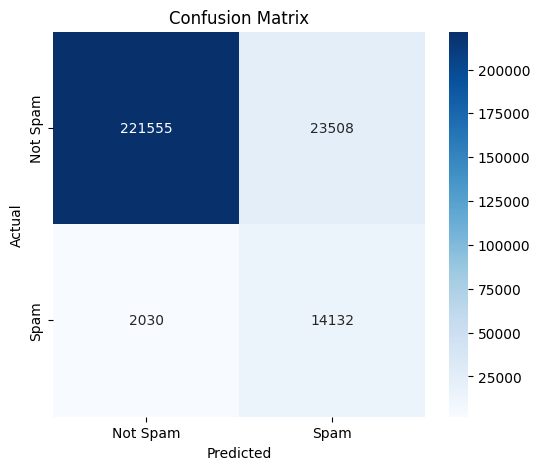


Classification Report:

              precision    recall  f1-score   support

           0     0.9909    0.9041    0.9455    245063
           1     0.3755    0.8744    0.5253     16162

    accuracy                         0.9022    261225
   macro avg     0.6832    0.8892    0.7354    261225
weighted avg     0.9528    0.9022    0.9195    261225

ROC AUC Score: 0.9530


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities and convert to binary (threshold = 0.5)
y_val_probs = model.predict(X_val_pad, batch_size=512)
y_val_pred = (y_val_probs >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision, Recall, F1
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred, digits=4))

# ROC AUC
roc_auc = roc_auc_score(y_val, y_val_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")